# Test of pointfusion gradslam algorithm with scfm

In [1]:
from argparse import ArgumentParser, RawTextHelpFormatter

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
from torch.utils.data import DataLoader

#from gradslam.datasets.tum import TUM
from end2endslam.dataloader.tum import TUM
from end2endslam.dataloader.nyu import NYU
from gradslam.slam.pointfusion import PointFusion
from gradslam.structures.pointclouds import Pointclouds
#from perception.SC_SfMLearner_Release.scsfmwrapper import SCSfmWrapper

from end2endslam.scsfmwrapper import SCSfmWrapper
#from end2endslam.losses import pred_loss_depth_consistency, pred_loss_reproj, pred_loss_depth
from losses.unified_loss import pred_loss_unified


from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from gradslam.structures.rgbdimages import RGBDImages

import numpy as np


import open3d as o3d


In [2]:
from matplotlib import pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#python pointfusion_scsfm_brucker.py --dataset tum --dataset_path "../../sample_data/dataset_TUM/" --odometry icp --loss depth_consistency

# FIRST POINTFUSION TEST

In [50]:
#create empty object and attach attributes, to simulate command line arguments
class Args: pass
args = Args()

args.dataset = "tum" #"nyu"
args.dataset_path = "../sample_data/dataset_TUM/" #"../sample_data/dataset_NYU/NYU_v2/"#"../../sample_data/dataset_TUM/"
args.odometry = "icp"
args.sequences = ("rgbd_dataset_freiburg1_xyz",) #None

args.seq_dilation = 2
args.seq_stride = None
args.seq_start = None

args.seed = 0

args.debug_path = None
args.seq_length = 10
args.batch_size = 8
args.loss = 'depth_consistency'

args.debug_path = "./debug/"
args.model_name = "test1"

args.loss_photo_factor=1
args.loss_geom_factor=0.5
args.loss_smooth_factor=0.1 
args.loss_cons_factor=0.1 
args.loss_gt_factor=0.1 

args.learning_rate=1e-6

args.log_freq=10

args.max_scale = 1


In [51]:
USE_GT_DEPTH = False #also disables training
VISUALIZE_SLAM = True

In [52]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(args.seed)

#original image size (hardcoded for TUM!)
ORIG_HEIGHT = 480
ORIG_WIDTH = 640

#image size used for depth prediction
DEPTH_PRED_HEIGHT = 256 #256
DEPTH_PRED_WIDTH = 320 #320

#image size used for SLAM
SLAM_HEIGHT = 64#128
SLAM_WIDTH = 80#160

#DEPTH PREDICTION MODEL PARAMETERS
#TODO: implement with args
CURR_DIR = './'#os.path.dirname(os.path.realpath(__file__))
MODEL_FILE = "models/r18_rectified_nyu/dispnet_model_best.pth.tar"
PRETRAINED_DISPNET_PATH = os.path.join(CURR_DIR, MODEL_FILE)
RESNET_LAYERS = 18

In [53]:
def slam_step(input_dict, slam, pointclouds, prev_frame, device, args):
    """ Perform SLAM step
    """
    # get inputs
    intrinsics = input_dict["intrinsic_slam"]
    colors = input_dict["rgb_slam"]
    # pass identity as poses (important for first frame, dummy for rest)
    if args.odometry == "gt":
        poses = input_dict["gt_poses"]
    else:
        poses = torch.eye(4, device=device).view(1, 4, 4).repeat(colors.shape[0], 1, 1)
    pred_depths = input_dict["pred_depths_slam"]

    # added artificial sequence length dimension and then don't use it (stupid but necessary)
    # permute since slam does NOT support channels_first = True
    colors_u = torch.unsqueeze(colors, 1).permute(0, 1, 3, 4, 2)
    pred_depths_u = torch.unsqueeze(pred_depths, 1).permute(0, 1, 3, 4, 2)
    poses_u = torch.unsqueeze(poses, 1)

    # SLAM
    rgbdimages = RGBDImages(colors_u, pred_depths_u, intrinsics, poses_u, channels_first=False, device=device)
    live_frame = rgbdimages[:, 0]
    pointclouds, live_frame.poses = slam.step(pointclouds, live_frame, prev_frame)

    # Compute relative poses for reprojection
    if prev_frame == None:
        relative_pose = live_frame.poses
    else:
        relative_pose = torch.matmul(torch.inverse(prev_frame.poses), live_frame.poses)

    return slam, pointclouds, live_frame, relative_pose


In [57]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Initialize DepthPrediction Network
depth_net = SCSfmWrapper(
    device=device,
    pretrained=True,
    pretrained_path=PRETRAINED_DISPNET_PATH,
    resnet_layers = RESNET_LAYERS)
optim = Adam(depth_net.parameters(), lr = args.learning_rate)

# load dataset
if args.dataset == "tum":
    #need to have images in 320x256 size as input to sc-sfml net. Thus first we rescale by 1.875, then crop horizontally
    height = DEPTH_PRED_HEIGHT#256 #640/2
    width = int(np.ceil(ORIG_WIDTH*(DEPTH_PRED_HEIGHT/ORIG_HEIGHT))) #342 #ceil(480/2)
    cropped_width = DEPTH_PRED_WIDTH #320 #crop hotizontally (equal margin at both sides)
    dataset = TUM(args.dataset_path, seqlen=args.seq_length, height=height, width=width, cropped_width=cropped_width, sequences=args.sequences,
                      dilation=args.seq_dilation,stride = args.seq_stride,start = args.seq_start)
elif args.dataset == "nyu":
    # right now only working with rectified pictures as provided by SfM-github
    dataset = NYU(args.dataset_path, version="rectified", seqlen=args.seq_length, height=DEPTH_PRED_HEIGHT, width=DEPTH_PRED_WIDTH, sequences=None)
elif args.dataset == "nyu-regular":
    # NOT SUPPORTET YET!!!
    dataset = NYU(args.dataset_path, version="regular", seqlen=args.seq_length, height=DEPTH_PRED_HEIGHT, width=DEPTH_PRED_WIDTH, sequences=None)

# get data
loader = DataLoader(dataset=dataset, batch_size=args.batch_size, shuffle=False )

writer = SummaryWriter()
model_path = os.path.join(args.debug_path, args.model_name)
if not os.path.exists(model_path):
    os.makedirs(model_path)

-> Loading model from  ./models/r18_rectified_nyu/dispnet_model_best.pth.tar


In [58]:
loader = DataLoader(dataset=dataset, batch_size=args.batch_size, shuffle=False )

In [59]:
#(colors, depths, intrinsics, poses, *_) = next(iter(loader))
(colors, depths, intrinsics, *rest) = next(iter(loader))#next(loader_iter)
batch_id = 0
batch_idx = 0
e_idx = 0

frame_id = 0

losses = []
counter = {"every": 0, "batch": 0, "detailed": 0}

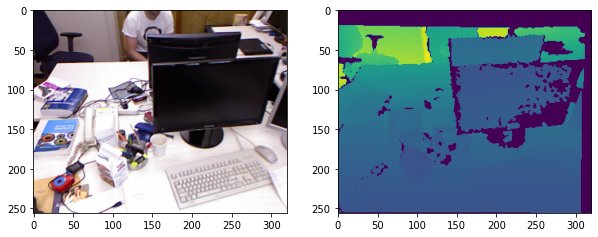

In [60]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,2,1)
ax.imshow(colors[batch_id,frame_id,:,:,:].detach().numpy().astype(np.uint))
ax = plt.subplot(1,2,2)
#ax.imshow(pred_depths[batch_id,frame_id+9,:,:,0].detach().numpy())
ax.imshow(depths[batch_id,frame_id,:,:,0].detach().numpy())

In [61]:
colors = colors.to(device)
depths = depths.to(device)
intrinsics = intrinsics.to(device)

# TODO: make NYU data loader return dummy gt poses
if args.dataset == 'tum':
    gt_poses = rest[0].to(device)
else:
    gt_poses = torch.eye(4, device=device).view(1, 4, 4).repeat(args.batch_size, args.seq_length, 1, 1)

# Hard coded
batch_loss = {}
pred_depths = []

# Initialize SLAM and pointclouds
slam = PointFusion(odom=args.odometry, dsratio=4, device=device)
pointclouds = Pointclouds(device=device)
live_frame = None

In [62]:
# Scale intrinsics since SLAM works on downsampled images
intrinsics_slam = intrinsics.clone().detach()
intrinsics_slam[:, :, 0, :] = intrinsics_slam[:, :, 0, :] * SLAM_WIDTH / DEPTH_PRED_WIDTH
intrinsics_slam[:, :, 1, :] = intrinsics_slam[:, :, 1, :] * SLAM_HEIGHT / DEPTH_PRED_HEIGHT
# Intrinsics are already scaled in TUM dataloader!
intrinsics_depth = intrinsics.clone().detach()

In [63]:
pred_index = -1

In [115]:
pred_index = pred_index+1
print("processing frame",pred_index)

depth_net.zero_grad()
    
# get input tensors
input_dict = {"device": device}
input_dict["rgb"] = (colors[:, pred_index, ::] / 255.0).permute(0, 3, 1, 2)
input_dict["rgb_ref"] = (colors[:, pred_index - 1, ::] / 255.0).permute(0, 3, 1, 2)

input_dict["depth"] = depths[:, pred_index, ::].permute(0, 3, 1, 2)
input_dict["depth_ref"] = depths[:, pred_index - 1, ::].permute(0, 3, 1, 2)
input_dict["gt_poses"] = gt_poses[:, pred_index, ::]
input_dict["intrinsic_slam"] = intrinsics_slam
input_dict["intrinsic_depth"] = intrinsics_depth

processing frame 3


In [116]:
# predict depth
# TODO: seems inefficient, could also store previous depth prediction
depth_net.eval()

depth_predictions = depth_net(input_dict["rgb"])
input_dict["pred_depths_ref"] = depth_net(input_dict["rgb_ref"])
input_dict["pred_depths"] = depth_predictions #[depth_net(input_dict["rgb"])]

#TODO: use it to test with gt depth
if USE_GT_DEPTH:
    print("WARNING: USING GT DEPTH")
    input_dict["pred_depths_ref"] = list()
    input_dict["pred_depths_ref"].append(input_dict["depth_ref"])
    input_dict["pred_depths"] = list()
    input_dict["pred_depths"].append(input_dict["depth"])

In [117]:
# Downsample (since depth prediction does not work in (120,160))
colors_slam = torch.nn.functional.interpolate(input=input_dict["rgb"], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="bicubic")

# Multi-scale: take largest scale only for SLAM
pred_depths_slam = torch.nn.functional.interpolate(input=input_dict["pred_depths"][0], size=(SLAM_HEIGHT, SLAM_WIDTH), mode="nearest")

input_dict["rgb_slam"] = colors_slam
input_dict["pred_depths_slam"] = pred_depths_slam

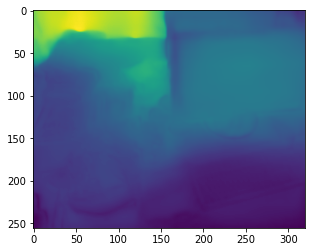

In [118]:
plt.imshow(input_dict["pred_depths"][0][0,0].detach())

In [119]:
# SLAM to update poses
slam, pointclouds, live_frame, relative_poses = slam_step(input_dict, slam, pointclouds, live_frame, device, args)
input_dict["pose"] = relative_poses.detach()
# TODO: use it to visualize SLAM
if False:
    # SLAM Vis
    o3d.visualization.draw_geometries([pointclouds.open3d(0)])

In [121]:
o3d.visualization.draw_geometries([pointclouds.open3d(6)])

In [139]:
o3d.visualization.draw_geometries([pointclouds.open3d(0),old_pointclouds.open3d(0)])

NameError: name 'old_pointclouds' is not defined

In [92]:
from losses.gt_loss import compute_errors

In [93]:
pred_t = input_dict["depth"]
gt_t = input_dict["depth_ref"]

In [94]:
pred = pred_t[:,0,:,:]
gt = gt_t[:,0,:,:]

In [95]:
compute_errors(pred,gt)

[0.6807461380958557,
 0.23152737319469452,
 0.5249432921409607,
 0.7952980399131775,
 0.8365651369094849,
 0.8585137128829956]

# POSE TEST

In [76]:
from __future__ import absolute_import, division, print_function

import warnings
import torch.nn as nn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
#from perception.SC_SfMLearner_Release.models import DispResNet

from models import DispResNet

import torch
from gradslam.structures.rgbdimages import RGBDImages
import imageio
#import open3d as o3d
from kornia.geometry.linalg import inverse_transformation
from gradslam.geometry.geometryutils import create_meshgrid 
#from end2endslam.loss_hamza.reprojection_loss import image2image
from loss_hamza.reprojection_loss import image2image

In [77]:
CURR_DIR = './'
MODEL_FILE = "models/r18_rectified_nyu/dispnet_model_best.pth.tar"
PRETRAINED_DISPNET_PATH = os.path.join(CURR_DIR, MODEL_FILE)
RESNET_LAYERS = 18

pretrained_path = PRETRAINED_DISPNET_PATH

pretrained_pose_path = "./models/r18_rectified_nyu/exp_pose_model_best.pth.tar"

resnet_layers = RESNET_LAYERS

In [78]:
#Create depth prediction network and load pretrained weights
disp_net = DispResNet(resnet_layers, False)#.to(device)

weights = torch.load(pretrained_path, map_location=device)
print("-> Loading model from ", pretrained_path)
#self.feed_height = loaded_dict_enc['height'] # Todo check if necessary
#self.feed_width = loaded_dict_enc['width']
disp_net.load_state_dict(weights['state_dict'])

disp_net.to(device)

#self.disp_net.eval() #set in eval mode... this CHANGES the behaviour of the net
disp_net.train() #set in train mode... this CHANGES the behaviour of the net
pass

-> Loading model from  ./models/r18_rectified_nyu/dispnet_model_best.pth.tar


In [79]:
from models import PoseResNet

print("-> Loading pose model from ", pretrained_pose_path)
weights = torch.load(pretrained_pose_path,map_location=torch.device('cpu'))
seq_length = 5
pose_net = PoseResNet(resnet_layers, False)#.to(device)
pose_net.load_state_dict(weights['state_dict'], strict=False)

pose_net.to(device)

pose_net.eval()
pass

-> Loading pose model from  ./models/r18_rectified_nyu/exp_pose_model_best.pth.tar


In [80]:
im1 = input_dict["rgb"]
im2 = input_dict["rgb_ref"]
im1 = ((im1 - 0.45)/0.225).to(device)
im2 = ((im2 - 0.45)/0.225).to(device)

pose_net(im2,im1)

tensor([[ 4.5535e-04,  4.4371e-04, -8.8396e-03,  4.4881e-03, -1.5712e-03,
          3.3362e-03],
        [ 8.9531e-05, -2.3105e-04, -5.0000e-04,  8.4973e-04, -4.5324e-04,
         -1.0111e-03],
        [ 1.0678e-04, -5.3308e-04,  8.1294e-03, -2.6729e-03, -3.5026e-03,
          2.5483e-03],
        [ 3.7907e-04,  3.4871e-04, -8.0078e-03,  4.1785e-03, -1.0517e-03,
          1.8222e-03],
        [ 4.0433e-04,  6.7561e-05,  3.3464e-04,  1.2260e-03, -2.4797e-03,
          9.8295e-03],
        [ 1.9688e-04, -7.6669e-04,  1.3117e-02, -4.6766e-03, -2.4366e-03,
          1.5709e-03],
        [ 2.9625e-04,  5.8928e-05, -8.8485e-03,  3.3066e-03, -1.8279e-03,
         -1.4460e-03],
        [ 8.2251e-04, -1.4517e-05,  3.1102e-03,  3.7596e-04,  1.6108e-04,
          7.5473e-03]], grad_fn=<MulBackward0>)

In [81]:
def compute_pose_with_inv(pose_net, tgt_img, ref_imgs):
    poses = []
    poses_inv = []
    for ref_img in ref_imgs:
        poses.append(pose_net(tgt_img, ref_img))
        poses_inv.append(pose_net(ref_img, tgt_img))

    return poses, poses_inv

In [82]:
pose,pose_inv = compute_pose_with_inv(pose_net,im2,[im1])

In [83]:
pose[0].shape

torch.Size([8, 6])

In [84]:
#from end2endslam.losses.photo_and_geometry_loss import photo_and_geometry_loss_wrapper
from end2endslam.losses.loss_utils.scsfm_loss import compute_photo_and_geometry_loss


def photo_and_geometry_loss_wrapper(args, input_dict):
    # certain stuff needs to be wrapped in lists
    intrinsics = input_dict["intrinsic_depth"]
    intrinsics = intrinsics[:, 0, 0:3, 0:3]
    poses = input_dict["pose"]
    poses_inv = torch.inverse(poses)
    poses = [poses[:, 0, 0:3, :]]
    poses_inv = [poses_inv[:, 0, 0:3, :]]
    tgt_img = input_dict["rgb"]
    ref_imgs = [input_dict["rgb_ref"]]

    # multi-scale
    tgt_depth = input_dict["pred_depths"]
    ref_depths = [input_dict["pred_depths_ref"]]

    photo_loss, geom_loss = compute_photo_and_geometry_loss(tgt_img, ref_imgs, intrinsics, tgt_depth, ref_depths,
                                    poses, poses_inv, max_scales=args.max_scale, with_ssim=1,
                                    with_mask=1, with_auto_mask=0, padding_mode='zeros')
    return photo_loss, geom_loss

In [85]:
photo_and_geometry_loss_wrapper(args,input_dict)

c:\users\david\projects\end-2-end-self-supervised-slam\end2endslam\losses\loss_utils\scsfm_loss.py:115: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  ..\aten\src\ATen\native\TensorIterator.cpp:924.)
  diff_img = (tgt_img - ref_img_warped).abs().clamp(0, 1)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(tensor(0.4664, grad_fn=<AddBackward0>),
 tensor(0.0486, grad_fn=<AddBackward0>))

In [86]:
im1 = input_dict["rgb"]
im2 = input_dict["rgb_ref"]
im1 = ((im1 - 0.45)/0.225).to(device)
im2 = ((im2 - 0.45)/0.225).to(device)
pose_net.eval()
poses_from_net,poses_inv_from_net = compute_pose_with_inv(pose_net,im1,[im2])
poses_from_net[0][0]

tensor([ 0.0005, -0.0007,  0.0153, -0.0058, -0.0004, -0.0003],
       grad_fn=<SelectBackward>)

In [100]:
USE_SLAM_POSES = True

In [124]:
gt_poses = input_dict["gt_poses"]

In [131]:
gt_poses[0]

tensor([[ 0.9991,  0.0060, -0.0418, -0.0105],
        [-0.0020,  0.9955,  0.0947,  0.0237],
        [ 0.0422, -0.0946,  0.9946,  0.1310],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [128]:
poses = input_dict["pose"]

In [129]:
poses = [poses[:, 0, 0:3, :]]

In [130]:
poses[0][0]

tensor([[ 0.9983, -0.0527,  0.0243, -0.0104],
        [ 0.0526,  0.9986,  0.0028,  0.0123],
        [-0.0244, -0.0016,  0.9997, -0.0061]])

In [91]:
poses_from_net[0] *= 10

In [92]:
poses_from_net[0][0]

tensor([ 0.0055, -0.0075,  0.1532, -0.0582, -0.0041, -0.0026],
       grad_fn=<SelectBackward>)

In [93]:
vec_pos = poses_from_net[0]

In [94]:
from end2endslam.losses.loss_utils.inverse_warp import pose_vec2mat
pose_vec2mat(vec_pos,'euler')[0].detach()

tensor([[ 1.0000,  0.0026, -0.0041,  0.0055],
        [-0.0023,  0.9983,  0.0581, -0.0075],
        [ 0.0042, -0.0581,  0.9983,  0.1532]])

In [132]:
POSES = 'gt'

In [134]:
from end2endslam.losses.loss_utils.scsfm_loss import compute_photo_and_geometry_loss

intrinsics = input_dict["intrinsic_depth"]
intrinsics = intrinsics[:, 0, 0:3, 0:3]

if POSES == 'slam':
    poses = input_dict["pose"]
    poses_inv = torch.inverse(poses)
    poses = [poses[:, 0, 0:3, :]]
    poses_inv = [poses_inv[:, 0, 0:3, :]]
elif POSES == 'gt':
    poses = input_dict["gt_poses"]
    poses_inv = torch.inverse(poses)
    poses = [poses[:, 0, 0:3, :]]
    poses_inv = [poses_inv[:, 0, 0:3, :]]
else:
    poses = poses_from_net
    poses_inv = poses_inv_from_net
    

tgt_img = input_dict["rgb"]
ref_imgs = [input_dict["rgb_ref"]]

# multi-scale
tgt_depth = input_dict["pred_depths"]
ref_depths = [input_dict["pred_depths_ref"]]

warped_res = {}

photo_loss, geom_loss = compute_photo_and_geometry_loss(tgt_img, ref_imgs, intrinsics, tgt_depth, ref_depths,
                                    poses, poses_inv, max_scales=args.max_scale, with_ssim=1,
                                    with_mask=1, with_auto_mask=0, padding_mode='zeros',warped_res=warped_res)

IndexError: too many indices for tensor of dimension 3

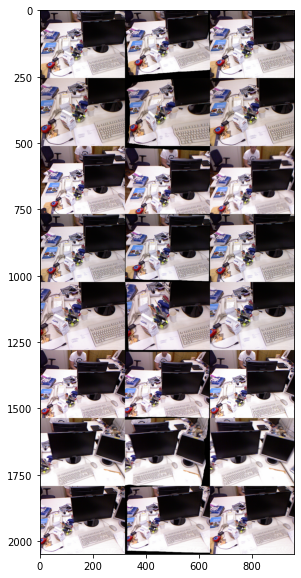

In [135]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,3,1)
ax.imshow(np.hstack([np.vstack(warped_res['color_ref'].numpy()),
                    np.vstack(warped_res['color_ref_warped'].numpy()),
                    np.vstack(warped_res['color_target'].numpy())]))

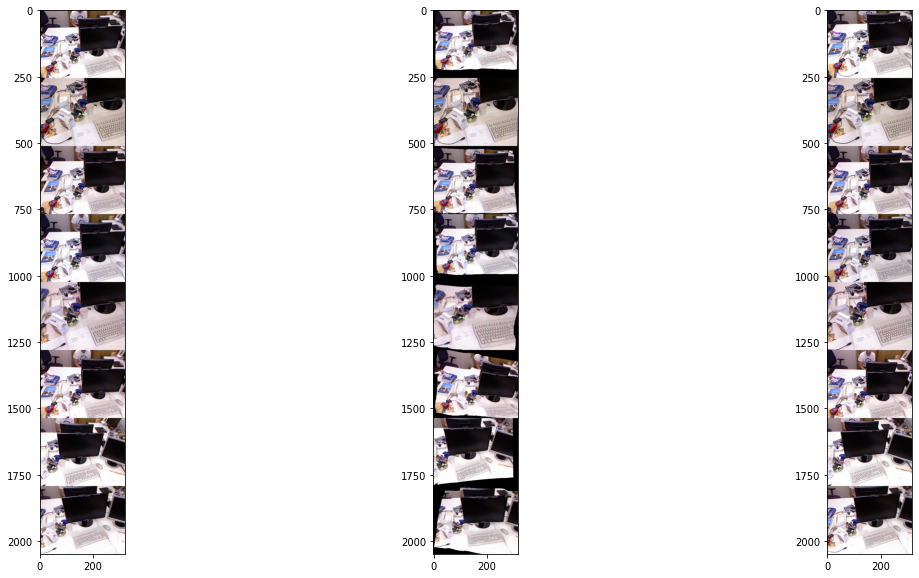

In [102]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,3,1)
ax.imshow(np.vstack(warped_res['color_ref'].numpy()))
ax = plt.subplot(1,3,2)
ax.imshow(np.vstack(warped_res['color_ref_warped'].numpy()))
ax = plt.subplot(1,3,3)
ax.imshow(np.vstack(warped_res['color_target'].numpy()))

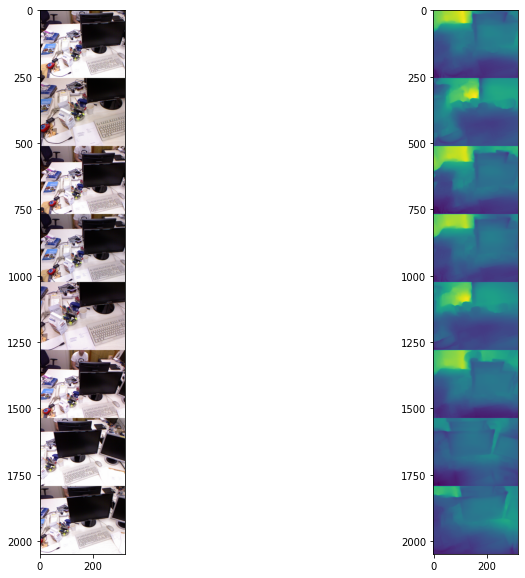

In [109]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,3,1)
ax.imshow(np.vstack(input_dict["rgb"].detach().cpu().permute(0, 2, 3, 1).squeeze().numpy()))
ax = plt.subplot(1,3,2)
ax.imshow(np.vstack(input_dict["pred_depths"][0].detach().cpu().permute(0, 2, 3, 1).squeeze().numpy()))